In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob

In [2]:
benchmark_results = []
for path in glob.glob('../benchmarks/2020-12-09-euler-plan-batch-test/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,micros_input,micros_precompute,micros_until_len,micros_edit_script,mpi_procs
213,56,remove,100000,0.50,0.0,zipf,0,0,mpi_no_master_frontier_simd,19275,0,1013739,0,8.0
93,53,remove,100000,0.25,0.0,zipf,0,0,mpi_priority_frontier,19587,0,1601818,0,1.0
126,66,remove,120000,0.25,0.0,zipf,0,0,mpi_priority_frontier,21888,0,268138,0,8.0
148,40,remove,80000,0.25,0.0,zipf,0,1,mpi_priority_frontier_simd,13271,0,1469308,0,1.0
50,21,addremove,40000,0.75,0.0,zipf,0,2,mpi_priority_frontier,8144,0,535999,0,8.0


In [3]:
def prepare_plot_data(filter_cb, index):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
    temp = filter_cb(temp)
    temp = temp.set_index(index, append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    return temp

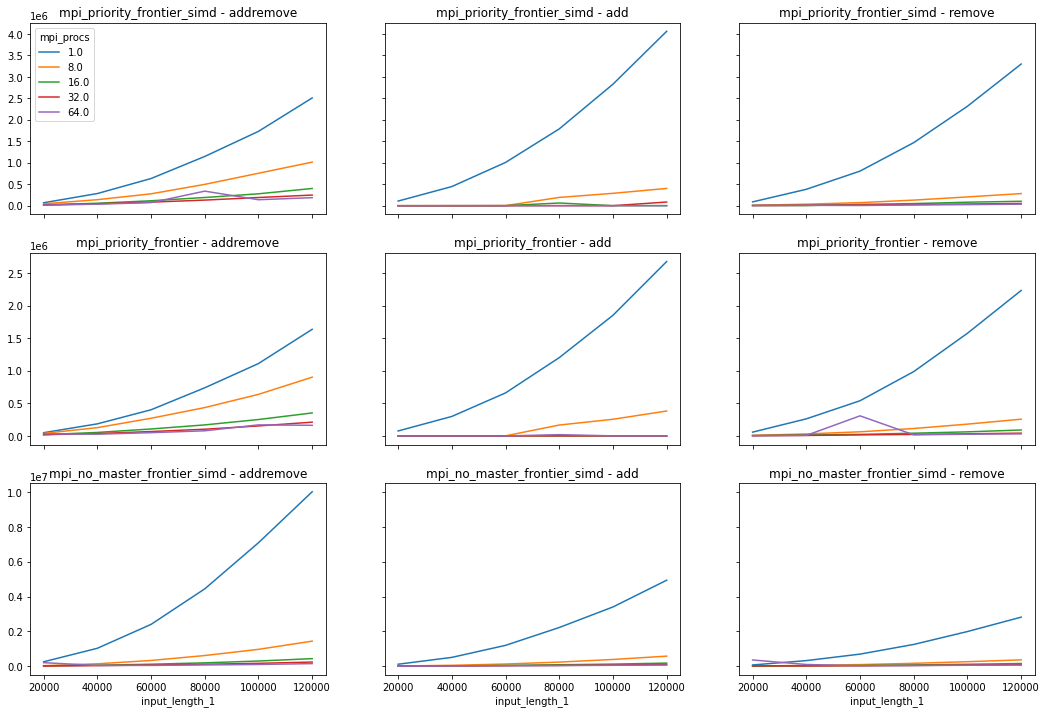

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey='row')
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier_simd', 'mpi_priority_frontier', 'mpi_no_master_frontier_simd']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == 0)],
            'input_length_1',
        )
        temp = temp.droplevel('diff_program')
        temp.plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}');

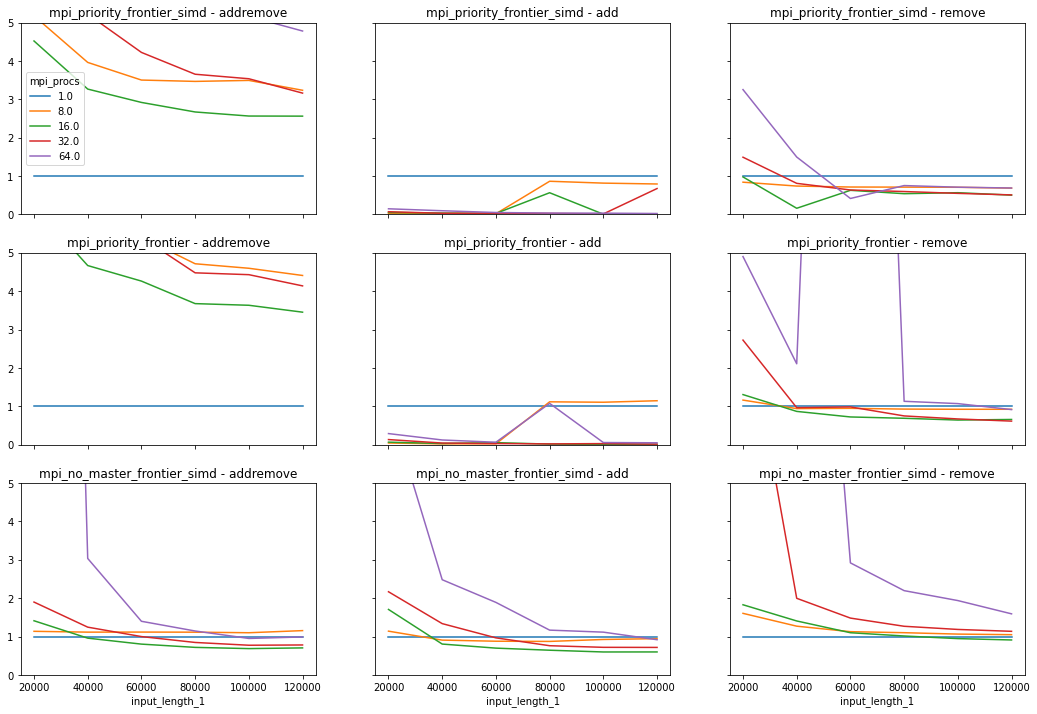

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier_simd', 'mpi_priority_frontier', 'mpi_no_master_frontier_simd']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == 0)],
            'input_length_1',
        )
        temp = temp.droplevel('diff_program')
        temp *= temp.columns.values
        temp = temp.divide(temp.loc[:, 1].values, axis=0)
        temp.plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}', ylim=(0, 5));

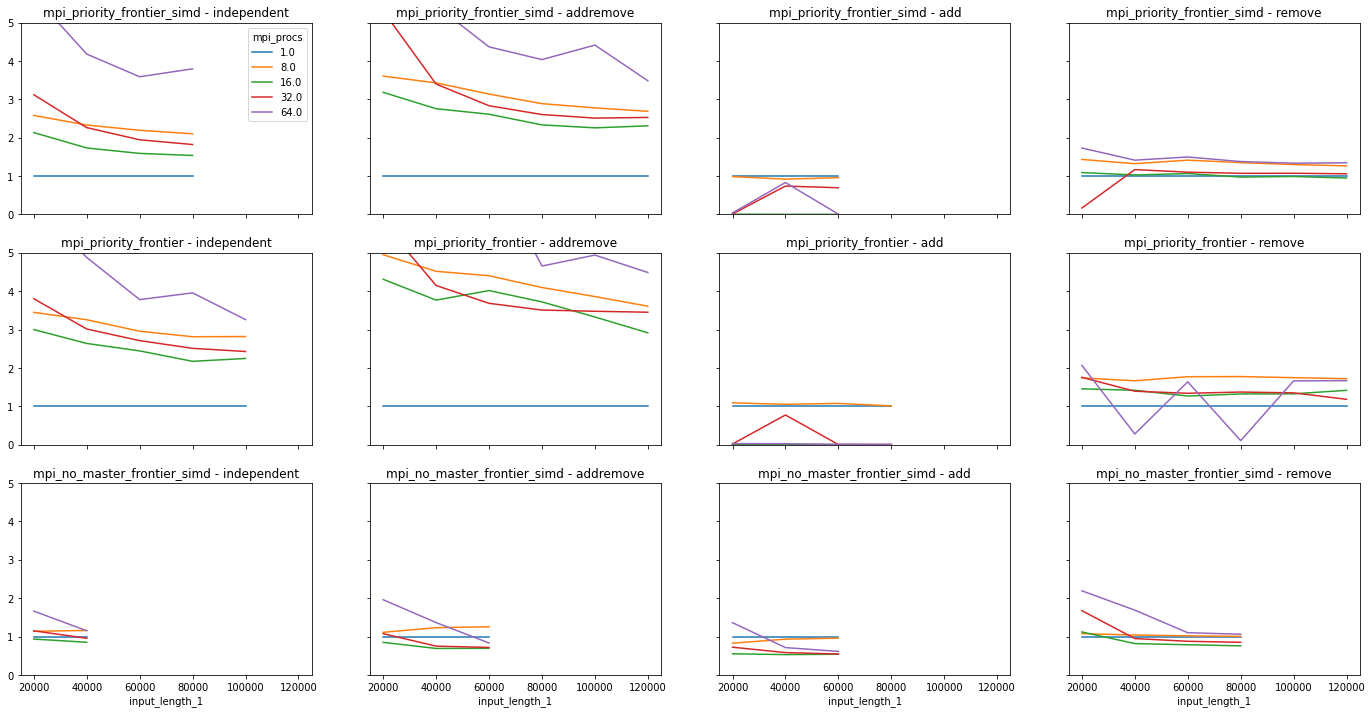

In [6]:
fig, ax = plt.subplots(3, 4, figsize=(24, 12), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier_simd', 'mpi_priority_frontier', 'mpi_no_master_frontier_simd']):
    for input_strategy_i, input_strategy in enumerate(['independent', 'addremove', 'add', 'remove']):
        temp = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].max()) & (temp['input_chunkiness'] == 0)],
            'input_length_1',
        )
        temp = temp.droplevel('diff_program')
        temp *= temp.columns.values
        temp = temp.divide(temp.loc[:, 1].values, axis=0)
        temp.plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}', ylim=(0, 5));